# Time series 2
Any time series may be split into the following components: Base Level + Trend + Seasonality + Error

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from random import gauss as gs
import datetime
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller, acf, pacf
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from matplotlib.pylab import rcParams
%matplotlib inline

In [2]:
fb = pd.read_csv('data/google-trends_football_us.csv').iloc[1:, :]
fb.columns = ['counts']

In [3]:
fb['counts'] = fb['counts'].replace('<1', '0')
fb['counts'] = fb['counts'].astype(int)

In [4]:
fb.info()

<class 'pandas.core.frame.DataFrame'>
Index: 185 entries, 2004-01 to 2019-05
Data columns (total 1 columns):
counts    185 non-null int64
dtypes: int64(1)
memory usage: 2.9+ KB


## Series as Both Predictor and Target?

Often, the phenomenon we want to capture with a time series is a dataset being correlated with *itself*.

Well, of course every dataset is perfectly correlated with itself. But what we're after now is the idea that a series is correlated with *earlier versions* of itself.

Consider the problem of trying to predict tomorrow's closing price for some stock on the market. One may consider lots of features, like what sort of company it is to which the stock belongs or whether that company has been in the news recently.

But it is very often the case that one of the most helpful predictors of tomorrow's price is *today's* price. And so we want to build a model where one of our predictors is an earlier version of our target.

One tool we can use is **`df.rolling()`**, which creates a Rolling object that we can use to calculate statistics dynamically.

In [5]:
fb.rolling(window=2).mean().head()

,counts
2004-01,NaN
2004-02,10.5
2004-03,8.0
2004-04,7.5
2004-05,8.0


In [6]:
fb['roll_avg'] = fb.rolling(window=2).mean()

fb.corr()

,counts,roll_avg
counts,1.000000,0.938216
roll_avg,0.938216,1.000000


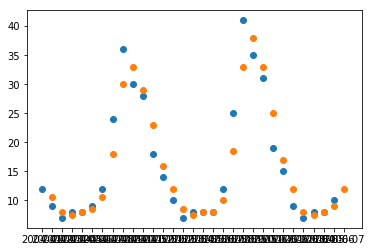

In [7]:
plt.scatter(fb.index[:30], fb['counts'][:30])
plt.scatter(fb.index[1:31], fb['roll_avg'][1:31]);

In [8]:
lr = LinearRegression()

lr.fit(fb[['roll_avg']][1:], fb['counts'][1:])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

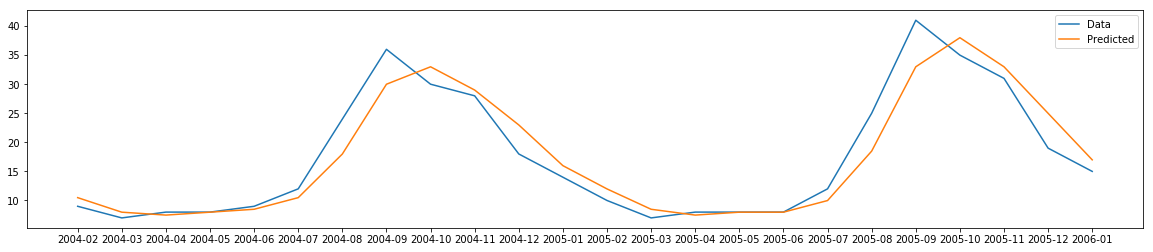

In [9]:
plt.figure(figsize=(20, 4))
plt.plot(fb.index[1:25], fb['counts'][1:25], label='Data')
plt.plot(fb.index[1:25], lr.predict(fb[['roll_avg']][1:25]),
         label='Predicted')
plt.legend();

## ARIMA Modeling 

Once you determine if your time series is stationary, you can model. There are 4 key steps: 
1. Model Identification - where you determine the properties of a time series then chose a structural form. Remember you're treating the data as a series of random variables. The basic types of ARIMA models are: 
    - AutoRegressive(AR)
    - Moving Average(MA) 
    - Autoregressive Moving Average(ARMA)
    - AutoRegressive Integrated Moving Average 
A time series may be primarily an autoregressive, moving average or combination of both. To identify which it is, you need to plot 2 key functions. 
    > Sample Autocorrelation Function(ACF) 
    > Sample Partial Autocorrelation Function(Partial ACF)
    
2. Parameter Estimation - Once you have identified the form of an ARIMA model, the next step is to estimate the coefficients or parameters of the model. You can use Regression and MLE to do this. 

3. Model Checking - The most widely used information criterion(checking the quality of your model) for Time series is AIC. You can compare different models with different numbers of lagged terms, white noise terms and how many times the time series was differenced and choose the model with the lowest AIC. 

4. Forecasting - Once the model is estimated you can forecast future values with the predict function. 

## Autocorrelation and Partial Autocorrelation
The ACF shows the correlations between the elements of a time series as a function of their lags. The partial ACF shows the correlations between the elements of a time series for each lag, holding constant the impact of all other lags.

>The basic idea of autocorrelation is simple: See how a series correlates with a "lagged" version of itself. If my sequence is $S_0 = (x_0, x_1, x_2, ... , x_n)$, then I can measure the Pearson correlation(multicollinearity) between the first $n-k + 1$ terms of $S_0$ and $S_{lag} = (x_k, x_{k+1}, x_{k+2}, ... , x_n)$.


In [10]:
acf(fb['counts'], nlags=20, fft=False)

array([ 1.        ,  0.75835271,  0.39614692, -0.02682356, -0.33671769,
       -0.51430013, -0.57433698, -0.50805221, -0.33213019, -0.03322244,
        0.35934472,  0.6897616 ,  0.9007188 ,  0.68924357,  0.35742731,
       -0.03006143, -0.31578315, -0.47909837, -0.53500615, -0.47438158,
       -0.31460724])

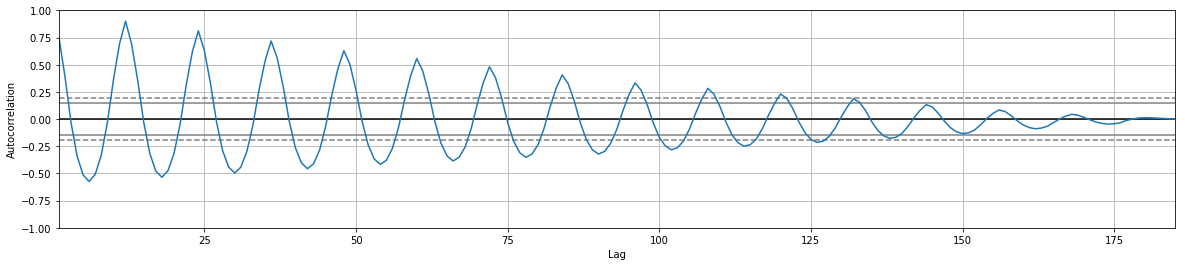

In [11]:
plt.figure(figsize=(20, 4))
pd.plotting.autocorrelation_plot(fb['counts']);

The horizontal bands represent condfidence intervals, which are calculated by taking relevant z-scores of the standard normal distribution and dividing by the square root of the number of observations. What do these intervals mean? - anything outside confidence interval means not due to chance - reject null. 


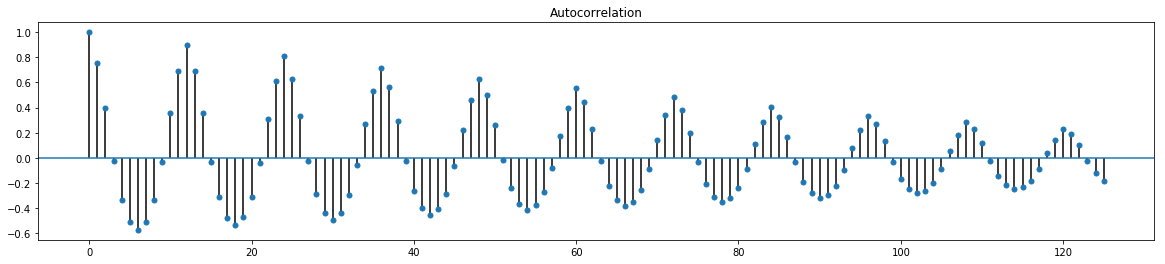

In [12]:
#We can also use the plot_acf() function from statsmodels:
rcParams['figure.figsize'] = 20, 4

plot_acf(fb['counts'], lags=125, alpha=None);

### Partial Autocorrelation
The idea behind partial Autocorrelation is to compare a series to a lagged version of itself while abstracting away from intermediate values. In effect, this amounts to exploring the correlations among residuals

In [13]:
pacf(fb['counts'], nlags=20)

array([ 1.        ,  0.76247419, -0.43209792, -0.39679619, -0.05921461,
       -0.13159449, -0.25344002, -0.09844008,  0.01124303,  0.2226528 ,
        0.47869494,  0.40442703,  0.78649095, -0.62389408, -0.02531833,
        0.24143533, -0.06033339, -0.01474157, -0.03507918, -0.04910669,
        0.00738705])

A common way of computing the partial autocorrelation is by fitting regressions to residuals from a simple dummy model that always predicts the mean. The coefficient of the final term will be the partial autocorrelation for the corresponding number of lags.

In [14]:
y_tilde = fb['counts'] - fb['counts'].mean()

In [15]:
x_1 = (fb['counts'][:-1] - fb['counts'].mean()).values.reshape(-1, 1)
x_2 = (fb['counts'][:-2] - fb['counts'].mean()).values.reshape(-1, 1)

In [16]:
lr = LinearRegression()

lr.fit(np.concatenate([x_1[1:], x_2], axis=1), y_tilde[2:]).coef_[-1]

-0.42286729591663597

In [17]:
x_1 = (fb['counts'][:-1] - fb['counts'].mean()).values.reshape(-1, 1)
x_2 = (fb['counts'][:-2] - fb['counts'].mean()).values.reshape(-1, 1)
x_3 = (fb['counts'][:-3] - fb['counts'].mean()).values.reshape(-1, 1)

In [18]:
lr2 = LinearRegression()

lr2.fit(np.concatenate([x_1[2:], x_2[1:], x_3], axis=1), y_tilde[3:]).coef_[-1]

-0.3855304642823899

## ARMA Modeling 
'AR' is for "Auto-Regressive": The prediction for today will be a function of the value for previous days.

The number of lag periods we want to include will be a parameter in the statsmodels model object ("p").

In particular, auto-regressive models look like this:

$X_t = \beta_0 + \Sigma^p_{i=1}\beta_iX_{t-i} + \epsilon_t$,
where $\epsilon_t$ should be more or less accurately modeled by white noise.

We indicate how many terms our $AR$ model has by writing $AR(k)$ where $k$ is the number of terms.

Looking at the PACF can help us decide on an appropriate $p$: We can look at where the correlation values cross the confidence thresholds.


'MA' is for "Moving Average": The prediction for today will be a function of the rolling mean.

The number of average terms we want to include will be a parameter in the statsmodels model object ("q").

In particular, moving-average models look like this:

$X_t = \mu + \epsilon_t + \Sigma^q_{i=1}\beta_i\epsilon_{t-i}$,
where again the $\epsilon$ should be modeled by white noise.

We indicate how many terms our $MA$ model has by writing $MA(k)$ where $k$ is the number of terms.

Looking at the ACF can help us decide on an appropriate $q$: We can look at where the correlation values cross the confidence thresholds.
The $AR$ and $MA$ models are intimately related. In fact $AR(p)$ is equivalent to $MA(\infty)$ for any $p$. The reverse holds as well if $|\theta| < 1$ for all $\theta$ in $MA(q)$. For more on this, see [here](https://otexts.com/fpp2/MA.html).

Consider $AR(1)$:

$X_t = \beta_0 + \beta_1X_{t-1} + \epsilon_t$ <br/> 
$= \beta_0 + \beta_1(\beta_1X_{t-2} + \epsilon_{t-1})$ <br/>
$= \beta_0 + \beta_1^2X_{t-2} + \beta_1\epsilon_{t-1}$ <br/>
$= \beta_0 + \beta_1^3X_{t-3} + \beta_1^2\epsilon_{t-2} + \beta_1\epsilon_{t-1}$

In the limit of this expansion we obtain an expression for $MA(\infty)$.

## Stationarity and the Dickey-Fuller Test

ARMA models assume that the time series is stationary, which means that its statistical properties are not a (meaningful) function of time. That is, the statistical properties of the series like mean, variance and autocorrelation are constant over time. A stationary time series is devoid of seasonal effects as well.

It may seem counterintuitive that, for modeling purposes, we want our time series not to be a function of time! But the basic idea is that we want our datapoints to be mutually independent. Why? 

One way of testing for stationarity is to use the Dickey-Fuller Test. The statsmodels version returns the test statistic and a p-value, relative to the null hypothesis that the series in question is NOT stationary.

In [19]:
# Presumably, our football series is not stationary. Let's check.
result = adfuller(fb['counts'], autolag=None)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))


ADF Statistic: 0.261460
p-value: 0.975506
Critical Values:
	1%: -3.469
	5%: -2.879
	10%: -2.576


In [20]:
#could try a log transform 
from numpy import log
X = log(fb['counts'])
result = adfuller(X, autolag=None)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -0.615355
p-value: 0.867475
Critical Values:
	1%: -3.469
	5%: -2.879
	10%: -2.576


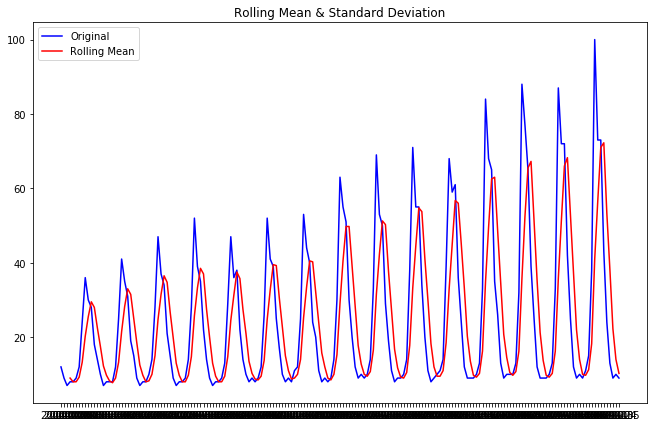

In [21]:
#rolling mean 
roll_mean = fb['counts'].rolling(window=4).mean()
fig = plt.figure(figsize=(11,7))
plt.plot(fb['counts'], color='blue',label='Original')
plt.plot(roll_mean, color='red', label='Rolling Mean')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [22]:
# Subtract the moving average from the original data
#we are taking the average of the last four values
#the rolling mean is not defined for the first three values.
data_minus_roll_mean = fb['counts'] - roll_mean
data_minus_roll_mean.head(15)

2004-01      NaN
2004-02      NaN
2004-03      NaN
2004-04    -1.00
2004-05     0.00
2004-06     1.00
2004-07     2.75
2004-08    10.75
2004-09    15.75
2004-10     4.50
2004-11    -1.50
2004-12   -10.00
2005-01    -8.50
2005-02    -7.50
2005-03    -5.25
Name: counts, dtype: float64

In [23]:
# Drop the missing values from time series calculated above
data_minus_roll_mean.dropna(inplace=True)

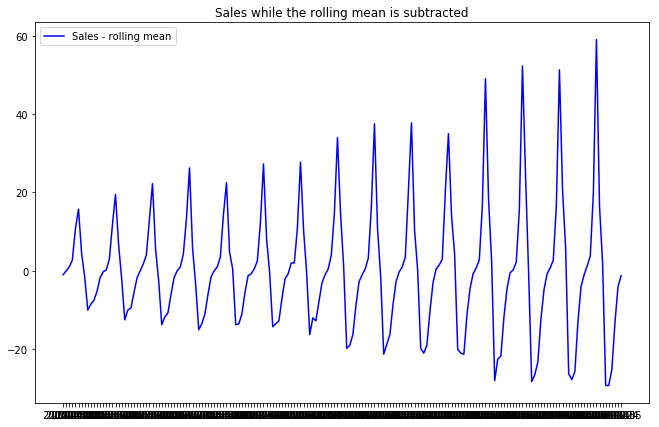

In [24]:
fig = plt.figure(figsize=(11,7))
plt.plot(data_minus_roll_mean, color='blue',label='Sales - rolling mean')
plt.legend(loc='best')
plt.title('Sales while the rolling mean is subtracted')
plt.show(block=False)

In [25]:
#differencing
data_diff = fb['counts'].diff(periods=1)
data_diff.head(10)

2004-01     NaN
2004-02    -3.0
2004-03    -2.0
2004-04     1.0
2004-05     0.0
2004-06     1.0
2004-07     3.0
2004-08    12.0
2004-09    12.0
2004-10    -6.0
Name: counts, dtype: float64

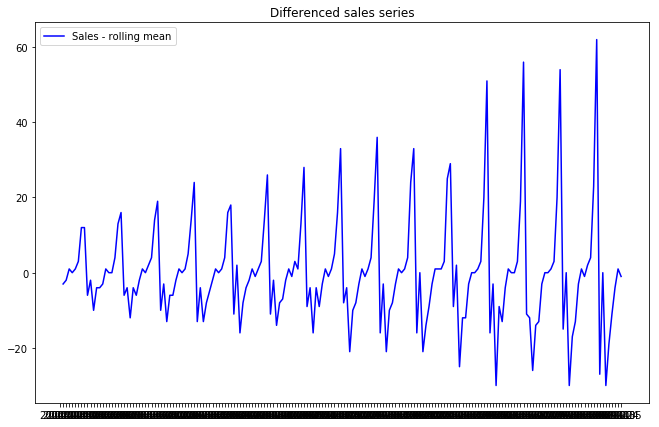

In [26]:
fig = plt.figure(figsize=(11,7))
plt.plot(data_diff, color='blue',label='Sales - rolling mean')
plt.legend(loc='best')
plt.title('Differenced sales series')
plt.show(block=False)

## ARMA Modeling 

In [28]:
# Instantiate & fit model with statsmodels
p = 3
q = 1

# This model will have three auto-regressive terms and one moving-average term.

ar = ARMA(fb['counts'].diff().values[1:], (p, q)).fit()

In [29]:
ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  184
Model:                     ARMA(3, 1)   Log Likelihood                -703.061
Method:                       css-mle   S.D. of innovations             10.875
Date:                Fri, 04 Dec 2020   AIC                           1418.121
Time:                        17:59:48   BIC                           1437.411
Sample:                             0   HQIC                          1425.939
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1063      0.029      3.716      0.000       0.050       0.162
ar.L1.y        0.8787      0.066     13.220      0.000       0.748       1.009
ar.L2.y        0.0114      0.093      0.123      0.903      -0.170       0.193
ar.L3.y       -0.4195      0.067     -6.303      0.000      -0.550      -0.289
ma.L1.y       -1.0000      0.014    -73.044      0.000      -1.027      -0.973
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.9284           -0.6640j            1.1414           -0.0988
AR.2            0.9284           +0.6640j            1.1414            0.0988
AR.3           -1.8298           -0.0000j            1.8298           -0.5000
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

In [30]:
r2_score(fb['counts'].diff().values[1:], ar.predict())

0.41518121229265725